<a href="https://colab.research.google.com/github/chandrakanta-chaudhury/deep_learning/blob/master/resnet_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
transform_train=transforms.Compose([transforms.RandomResizedCrop(224),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),])
transform_test=transforms.Compose([transforms.RandomResizedCrop(224),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),])

In [4]:
trainset=torchvision.datasets.CIFAR10(root='/home/chandrakanta/Downloads',train=True,download=True,transform=transform_train)
testset=torchvision.datasets.CIFAR10(root='/home/chandrakanta/Downloads',train=False,download=True,transform=transform_test)


Files already downloaded and verified
Files already downloaded and verified


In [0]:
num_classes=10
batch_size=4

In [0]:
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader=torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=True)

In [0]:
from torchvision import models

In [8]:
resnet=models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 28369143.11it/s]


In [9]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
for param in resnet.parameters():
  param.requires_grad=False
  
  
  

In [0]:
in_features=resnet.fc.in_features
resnet.fc=nn.Linear(in_features,num_classes)


In [12]:
for param in resnet.parameters():
  if param.requires_grad:
    print(param.shape)
    

torch.Size([10, 512])
torch.Size([10])


In [0]:
resnet=resnet.to(device)
loss_fn=nn.CrossEntropyLoss()
opt=optim.SGD(resnet.parameters(),lr=0.01)


In [0]:
def evaluation(dataloader,model):
  total,correct=0,0
  for data in dataloader:
    inputs,labels=data
    inputs,labels=inputs.to(device),labels.to(device)
    outputs=model(inputs)
    _,pred=torch.max(outputs.data,1)
    total+=labels.size(0)
    correct+=(pred==labels).sum().item()
  return  100 * correct /total


min loss 0.91
min loss 0.80
min loss 0.21
min loss 0.14
min loss 0.11
min loss 0.07
min loss 0.05
epoch: 0 4, test acc: 45.98,train acc: 45.47
min loss 0.04
epoch: 1 4, test acc: 43.67,train acc: 44.30
min loss 0.03
min loss 0.02
epoch: 2 4, test acc: 41.01,train acc: 41.24
epoch: 3 4, test acc: 42.30,train acc: 43.21


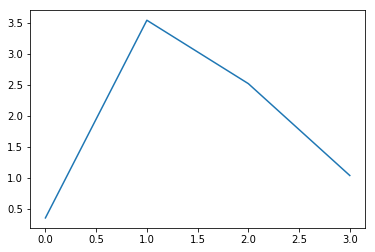

In [18]:
import copy
loss_epoch_arr=[]
max_epochs=4
min_loss=1000
n_iters=np.ceil(50000/batch_size)
for epoch in range(max_epochs):
  for i ,data in enumerate(trainloader,0):
    inputs,labels=data
    inputs,labels=inputs.to(device),labels.to(device)
    opt.zero_grad()
    outputs=resnet(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    opt.step()
    if min_loss > loss.item():
      min_loss=loss.item()
      best_model=copy.deepcopy(resnet.state_dict())
      print('min loss %0.2f' % min_loss)
    if 1 % 100 == 0:
      print('iteration: %d/%d,loss: %0.2f' %(i,n_iters,loss.item()))
    del inputs,outputs,labels
    torch.cuda.empty_cache()
  loss_epoch_arr.append(loss.item())
  print('epoch: %d %d, test acc: %0.2f,train acc: %0.2f' %(epoch,max_epochs,evaluation(testloader,resnet),evaluation(trainloader,resnet)))
plt.plot(loss_epoch_arr)
plt.show()


In [19]:
resnet.load_state_dict(best_model)
print(evaluation(trainloader,resnet),evaluation(testloader,resnet))


43.606 43.19
